In [87]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import mplfinance as mpf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import torch
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# NEW THINGS

In [12]:
stock_name = "AAPL"

In [137]:
def prepare_daily_data(stock_name, period="5d", interval="1m"):
    recent_data = yf.download(stock_name, period=period, interval=interval)
    recent_data = recent_data.drop(columns=["Adj Close"])

    segment = 390 if interval == "1m" else 7

    for i in range(1, segment):
        recent_data[f"Open t - {i}"] = recent_data["Open"].shift(i)
        recent_data[f"Close t - {i}"] = recent_data["Close"].shift(i)
        recent_data[f"High t - {i}"] = recent_data["High"].shift(i)
        recent_data[f"Low t - {i}"] = recent_data["Low"].shift(i)

    recent_data.dropna(inplace=True)
    first_timestamp = recent_data.index[0]

    if first_timestamp.time() != pd.Timestamp("09:30:00").time():
        index = recent_data.index.get_loc(
            recent_data[
                recent_data.index.time == pd.Timestamp("09:30:00").time()
            ].index[0]
        )
        recent_data = recent_data.iloc[index:]

    # Split data into daily segments
    recent_data["day_index"] = recent_data.index.date
    recent_data["day_index"], _ = pd.factorize(recent_data["day_index"])
    daily_data = [group for _, group in recent_data.groupby("day_index")]

    # Add movement column to each daily DataFrame
    for day_data in daily_data:
        day_data["movement"] = (
            day_data["Close"].iloc[-1] > day_data["Open"].iloc[0]
        ).astype(int)

    combined_data = pd.concat(daily_data)

    last_hour_data = combined_data.groupby("day_index").apply(lambda x: x.iloc[-1])

    return last_hour_data

daily_data = prepare_daily_data(stock_name, period="1mo", interval="1h")

print(daily_data.to_markdown())

# print(daily_data["Index"] == 0)

# def split_data(recent_data, interval="1m"):
#     segment = 390 if interval == "1m" else 7
#     if type(recent_data) == pd.DataFrame:
#         day_segments = [
#             recent_data.iloc[i : i + segment] for i in range(0, len(recent_data), segment)
#         ]
#     else:
#         day_segments = torch.from_numpy(np.array([
#             recent_data[i : i + segment] for i in range(0, len(recent_data), segment)
#         ]))
#     return day_segments

[*********************100%%**********************]  1 of 1 completed

| Datetime                  |    Open |    High |     Low |   Close |      Volume |   Open t - 1 |   Close t - 1 |   High t - 1 |   Low t - 1 |   Open t - 2 |   Close t - 2 |   High t - 2 |   Low t - 2 |   Open t - 3 |   Close t - 3 |   High t - 3 |   Low t - 3 |   Open t - 4 |   Close t - 4 |   High t - 4 |   Low t - 4 |   Open t - 5 |   Close t - 5 |   High t - 5 |   Low t - 5 |   Open t - 6 |   Close t - 6 |   High t - 6 |   Low t - 6 |   day_index |   movement |
|:--------------------------|--------:|--------:|--------:|--------:|------------:|-------------:|--------------:|-------------:|------------:|-------------:|--------------:|-------------:|------------:|-------------:|--------------:|-------------:|------------:|-------------:|--------------:|-------------:|------------:|-------------:|--------------:|-------------:|------------:|-------------:|--------------:|-------------:|------------:|------------:|-----------:|
| 2024-07-11 09:30:00-04:00 | 231.312 | 232.39  | 228.53  


C:\Users\yahli\AppData\Local\Temp\ipykernel_25168\2548426444.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  last_hour_data = daily_data.groupby("day_index").apply(lambda x: x.iloc[-1])


In [95]:
from sklearn.model_selection import train_test_split
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

X = recent_data.drop(["Close", "Volume", "High", "Low","movement"], axis=1)
y = recent_data[["movement"]]

X_tensor = torch.from_numpy(X.values)
y_tensor = torch.from_numpy(y.values)
print(X_tensor.shape)
print(y_tensor.shape)
# print(X)

print(split_data(X_tensor, interval="1h").shape)


X_train,X_test,y_train,y_test = train_test_split(X_tensor,y_tensor,test_size=0.2)
X_train = X_train.to(torch.float32).to(device)
# X_time_step = [i for i in range(len(X_train))]
X_test= X_test.to(torch.float32).to(device)
y_train = y_train.to(torch.float32).to(device)
y_test =y_test.to(torch.float32).to(device)

torch.Size([147, 41])
torch.Size([147, 1])
torch.Size([21, 7, 41])


In [11]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=2):
        super(LSTMPredictor, self).__init__()

        self.ltsm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
        )
    def forward(self, sequences):
        lstm_out, (hn, cn) = self.ltsm(sequences)
        return lstm_out
    
model = nn.Sequential(
    
    LSTMPredictor(input_size=42, hidden_size=128, n_layers=10),
    nn.Linear(128, 3),
    
).to(device)

# model(X_train)

In [12]:
X_train

tensor([[218.0500, 218.2800, 217.7950,  ..., 222.6000, 223.0100, 222.0801],
        [234.5500, 234.8100, 234.3995,  ..., 234.6900, 235.8800, 234.6200],
        [209.4500, 208.5050, 209.0100,  ..., 212.6150, 213.0000, 209.5050],
        ...,
        [231.9000, 230.7100, 230.8800,  ..., 232.9100, 233.0800, 231.7050],
        [225.0600, 224.6800, 224.3700,  ..., 223.9450, 225.0500, 223.5600],
        [222.9800, 223.3500, 227.8700,  ..., 234.8100, 234.9800, 234.2850]],
       device='cuda:0')

In [13]:
epochs = 10000

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for batch in range(day_segments.shape[0]):
    for epoch in range(epochs):
        model.train()

        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        model.eval()
        with torch.inference_mode():
            y_test_pred = model(X_test)
            test_loss = loss_fn(y_test_pred, y_test)
            if epoch % 100 == 0:
                print(f"epoch: {epoch} loss = {loss}, test loss = {test_loss}")

c:\Users\yahli\anaconda3\envs\Stocks\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([120, 1])) that is different to the input size (torch.Size([120, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\yahli\anaconda3\envs\Stocks\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([30, 1])) that is different to the input size (torch.Size([30, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0 loss = 0.5180712342262268, test loss = 0.33002859354019165
epoch: 100 loss = 0.24900199472904205, test loss = 0.25493112206459045
epoch: 200 loss = 0.2421465367078781, test loss = 0.25643104314804077
epoch: 300 loss = 0.23525935411453247, test loss = 0.25656113028526306
epoch: 400 loss = 0.25251445174217224, test loss = 0.2520330250263214
epoch: 500 loss = 0.23902182281017303, test loss = 0.24695584177970886
epoch: 600 loss = 0.23703745007514954, test loss = 0.23847584426403046
epoch: 700 loss = 0.2318083494901657, test loss = 0.23384281992912292
epoch: 800 loss = 0.22248727083206177, test loss = 0.2339828610420227
epoch: 900 loss = 0.21531745791435242, test loss = 0.273252010345459
epoch: 1000 loss = 0.20839254558086395, test loss = 0.3173498511314392
epoch: 1100 loss = 0.22593697905540466, test loss = 0.2466966211795807
epoch: 1200 loss = 0.2190409004688263, test loss = 0.26273536682128906
epoch: 1300 loss = 0.24034790694713593, test loss = 0.2403080016374588
epoch: 1400 los

KeyboardInterrupt: 

In [ ]:
torch.save(model, "model1.pt")

In [ ]:
def prepare_test_loop_data(stock_name, period="5d", interval="1m",back_time=5, answers =[]):

    recent_data = yf.download(stock_name, period=period, interval=interval)

    data_200 = yf.download(stock_name, period=period, interval=interval).tail(len(recent_data) + 201)
    data_200 = data_200.drop(columns=["Adj Close"])

    data_200.fillna(method="bfill", inplace=True)

    #recent_data = data_200.tail(len(recent_data))


    recent_data = recent_data.dropna()
    for i in range(back_time):
        recent_data[f"Open t - {i+1}"] = recent_data["Open"].shift((i+1))
        recent_data[f"Close t - {i+1}"] = recent_data["Close"].shift((i+1))
        recent_data[f"High t - {i+1}"] = recent_data["High"].shift((i+1))
        recent_data[f"Low t - {i+1}"] = recent_data["Low"].shift((i+1))
    recent_data["movement"] = (recent_data["Close"] > recent_data["Open"]).astype(int)

    # recent_data = recent_data.tail(1)
    # add_plot = mpf.make_addplot(recent_data["200_day"], color="blue", linestyle="--")

    return recent_data

#recent_data = prepare_test_loop_data(stock_name,back_time=1,answers=[answer])
#recent_data.head()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


tensor([[99.4466, 99.3560, 99.5622]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[99.4466, 99.3560, 99.5622]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[99.4466, 99.3560, 99.5622]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[99.4466, 99.3560, 99.5622]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[99.4466, 99.3560, 99.5622]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[99.4466, 99.3560, 99.5622]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[99.4466, 99.3560, 99.5622]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[99.4466, 99.3560, 99.5622]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[99.4466, 99.3560, 99.5622]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[99.4466, 99.3560, 99.5622]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


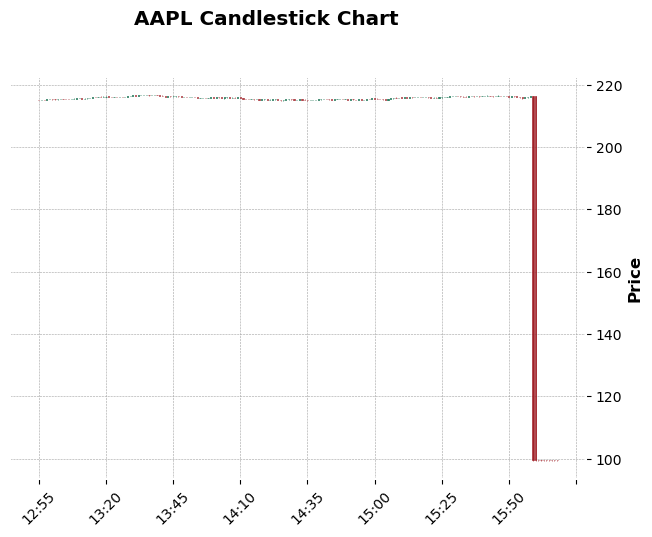

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

answers = []
forcast = 10
check_data = prepare_test_loop_data(
    interval="1m", back_time=10, period="1d", stock_name=stock_name
)
date_range = pd.date_range(
    start=check_data.index[-1], periods=forcast, freq="1T"
)  # Generate a date range



for i in range(forcast):
    # for i in answers:

    check_data_last = check_data.tail(1)
    check_X = check_data_last.drop(["Close", "Volume", "High", "Low","movement"], axis=1)
    check_y = check_data_last[["movement"]]

    # print(check_data.tail(6).to_markdown())
    # print(X.shape)

    check_X_tensor = torch.from_numpy(check_X.values)
    check_y_tensor = torch.from_numpy(check_y.values)

    check_X_tensor = check_X_tensor.to(torch.float32).to(device)
    check_y_tensor = check_y_tensor.to(torch.float32).to(device)

    # print(check_data_last.to_markdown(), "\n\n\n")

    answer = model(check_X_tensor)

    print(answer)

    answer = answer.detach().cpu().numpy()

    answer = np.append(answer[0],check_X["Close t - 1"])
    answers.append(answer)
    df = pd.DataFrame(
        {
            "Close": [answers[-1][0]],
            "High": [answers[-1][1]],
            "Low": [answers[-1][2]],
            "Open": [answers[-1][3]],
            "Adj Close": [0],
            "Volume": [0],
        },
        index=[date_range[i]],
    )

    check_data = check_data._append(df)
    for i in range(10):
        check_data[f"Open t - {i+1}"] = check_data["Open"].shift((i + 1))
        check_data[f"Close t - {i+1}"] = check_data["Close"].shift((i + 1))
        check_data[f"High t - {i+1}"] = check_data["High"].shift((i + 1))
        check_data[f"Low t - {i+1}"] = check_data["Low"].shift((i + 1))
    recent_data["movement"] = (recent_data["Close"] > recent_data["Open"]).astype(int)

    # check_data.dropna(inplace=True)
# print(check_data.to_markdown())

# print(check_data)
# print(answers)

# sns.catplot(answer[0][:],label="Predicted")
last_elements = [arr[0] for arr in answers]

recent_data = prepare_data(stock_name, period="1d", interval="1m")
# print("Converted index to datetime")

answers_df = pd.concat(
    [
        pd.DataFrame(
            recent_data,
            columns=["Close", "High", "Low", "Open","movement"],
        ),
        pd.DataFrame(
            answers, columns=["movement"], index=date_range
        ),
    ]
).iloc[200:]

# print(answers_df.tail(100))

mpf.plot(
    answers_df,
    type="candle",
    style="charles",
    title=f"{stock_name} Candlestick Chart",
    ylabel="Price",
)